In [1]:
import numpy as np
import pandas as pd
import datetime
import re
from itertools import chain
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

from __future__ import print_function

In [2]:
# Preprocessing data and helpers
number = re.compile('[\d,]+')
def get_first_number(val):
    matched = number.match(str(val))
    if matched:
        return int(matched.group().replace(',', ''))
    else:
        return np.nan

def dict_map(dict_to_use):
    def mapper(val):
        if val in dict_to_use:
            return dict_to_use[val]
        else:
            return np.nan

    return mapper

def split_list(list_str):
    if pd.isnull(list_str):
        return []
    else:
        return np.core.defchararray.split(list_str, sep='; ')

def userlist_to_cols(col):
    # col = col.where(col.notnull(), None)
    list_elems = col.astype('string').apply(split_list)
    categories = set(chain.from_iterable(list_elems.values))
    categories.discard('nan')
    categories = pd.Series(list(categories))
    
    def category_to_cols(category):
        return list_elems.map(lambda user_resp: category in user_resp)\
                         .rename('%s_%s' % (col.name, category))\
                         .astype('int8')
    
    new_cols = categories.map(category_to_cols)
    return pd.concat(new_cols.values, axis=1)

def timestr_to_number(timestr):
    if timestr == 'Noon':
        return 12
    elif timestr == 'Midnight':
        return 0
    else:
        return datetime.datetime.strptime(timestr, '%I:%M %p').hour

listvals = [
    'DeveloperType',
    'NonDeveloperType',
    'ImportantBenefits',
    'JobProfile',
    'EducationTypes',
    'SelfTaughtTypes',
    'CousinEducation',
    'HaveWorkedLanguage',
    'WantWorkLanguage',
    'HaveWorkedFramework',
    'WantWorkFramework',
    'HaveWorkedDatabase',
    'WantWorkDatabase',
    'HaveWorkedPlatform',
    'WantWorkPlatform',
    'IDE',
    'Methodology',
    'MetricAssess',
    'StackOverflowDevices',
    'Race',
]

number_parses = [
    'CompanySize',
    'YearsProgram',
    'YearsCodedJob',
    'YearsCodedJobPast',
]

agree_keys = [
    'ExCoderReturn',
    'ExCoderNotForMe',
    'ExCoderBalance',
    'ExCoder10Years',
    'ExCoderBelonged',
    'ExCoderSkills',
    'ExCoderWillNotCode',
    'ExCoderActive',
    'ProblemSolving',
    'BuildingThings',
    'LearningNewTech',
    'BoringDetails',
    'JobSecurity',
    'DiversityImportant',
    'AnnoyingUI',
    'FriendsDevelopers',
    'RightWrongWay',
    'UnderstandComputers',
    'SeriousWork',
    'InvestTimeTools',
    'WorkPayCare',
    'KinshipDevelopers',
    'ChallengeMyself',
    'CompetePeers',
    'ChangeWorld',
    'ShipIt',
    'OtherPeoplesCode',
    'ProjectManagement',
    'EnjoyDebugging',
    'InTheZone',
    'CollaborateRemote',
    'StackOverflowAdsRelevant',
    'StackOverflowAdsDistracting',
    'StackOverflowModeration',
    'StackOverflowCommunity',
    'StackOverflowHelpful',
    'StackOverflowBetter',
    'StackOverflowWhatDo',
    'StackOverflowMakeMoney',
    'SurveyLong',
    'QuestionsInteresting',
    'QuestionsConfusing',
    'InterestedAnswers',
]

important_keys = [
    'AssessJobRole',
    'AssessJobExp',
    'AssessJobDept',
    'AssessJobTech',
    'AssessJobProjects',
    'AssessJobCompensation',
    'AssessJobOffice',
    'AssessJobCommute',
    'AssessJobRemote',
    'AssessJobLeaders',
    'AssessJobProfDevel',
    'AssessJobDiversity',
    'AssessJobProduct',
    'AssessJobFinances',
    'ImportantHiringAlgorithms',
    'ImportantHiringTechExp',
    'ImportantHiringCommunication',
    'ImportantHiringOpenSource',
    'ImportantHiringPMExp',
    'ImportantHiringCompanies',
    'ImportantHiringTitles',
    'ImportantHiringEducation',
    'ImportantHiringRep',
    'ImportantHiringGettingThingsDone',
    'EducationImportant',
]

satisfied_keys = [
    'EquipmentSatisfiedMonitors',
    'EquipmentSatisfiedCPU',
    'EquipmentSatisfiedRAM',
    'EquipmentSatisfiedStorage',
    'EquipmentSatisfiedRW',
    'InfluenceInternet',
]

influence_keys = [
    'InfluenceWorkstation',
    'InfluenceHardware',
]

yes_no_keys = [
    'ClickyKeys',
]

last_three_months_keys = [
    'StackOverflowCopiedCode',
    'StackOverflowJobListing',
    'StackOverflowCompanyPage',
    'StackOverflowJobSearch',
    'StackOverflowNewQuestion',
    'StackOverflowAnswer',
    'StackOverflowMetaChat',
]

last_three_months_strs = {
    'Several times': 5,
    'At least once each day': 4,
    'At least once each week': 3,
    'Once or twice': 2,
    "Haven't done at all": 1,
}

yes_no_strs = {
    'Yes': 1,
    'No': 0,
}

influence_strs = {
    'I am the final decision maker': 5,
    'A lot of influence': 4,
    'Some influence': 3,
    'Not much influence': 2,
    'No influence at all': 1,
}

agree_strs = {
    'Strongly Agree': 5,
    'Agree': 4,
    'Somewhat agree': 3,
    'Somewhat disagree': 2,
    'Disagree': 1,
    'Strongly disagree': 0,
}

satisfied_strs = {
    'Very satisfied': 5,
    'Satisfied': 4,
    'Somewhat satisfied': 3,
    'Not very satisfied': 2,
    'Not at all satisfied': 1,
}

important_strs = {
    'Very important': 5,
    'Somewhat important': 4,
    'Important': 3,
    'Not very important': 2,
    'Not at all important': 1,
}

overpaid_strs = {
    'Greatly overpaid': 5,
    'Somewhat overpaid': 4,
    'Neither underpaid nor overpaid': 3,
    'Somewhat underpaid': 2,
    'Greatly underpaid': 1,
}

checkin_strs = {
    'Never': 5,
    'Just a few times over the year': 4,
    'A few times a month': 3,
    'A few times a week': 2,
    'Once a day': 1,
    'Multiple times a day': 0,
}

to_drop = listvals + [
    'Gender',
    'JobSeekingStatus',
    'Respondent',
]


replacers = [
    (influence_keys, influence_strs),
    (agree_keys, agree_strs),
    (satisfied_keys, satisfied_strs),
    (['CheckInCode'], checkin_strs),
    (['Overpaid'], overpaid_strs),
    (last_three_months_keys, last_three_months_strs),
    (important_keys, important_strs),
    (yes_no_keys, yes_no_strs),
]


# 2017 preproc
data = pd.read_csv('data/2017.csv')
data = data[data['JobSatisfaction'].notnull()]

data['gender_M'] = (data['Gender'] == 'Male').astype('int8')
data['gender_F'] = (data['Gender'] == 'Female').astype('int8')

for keys, strs in replacers:
    data[keys] = data[keys].applymap(dict_map(strs)).astype('float')

for index in listvals:
    data = pd.concat([data, userlist_to_cols(data[index])], axis=1)

data[number_parses] = data[number_parses].applymap(get_first_number).astype('float')

data.drop(to_drop, axis=1, inplace=True)
data = pd.get_dummies(data)

print('Columns with NaNs:')
for key in data:
    if data[key].isnull().any():
        print(key)
data.fillna(data.mean(), inplace=True)
print('Filling with mean of column')

Columns with NaNs:
CompanySize
YearsProgram
YearsCodedJob
YearsCodedJobPast
CareerSatisfaction
ExCoderReturn
ExCoderNotForMe
ExCoderBalance
ExCoder10Years
ExCoderBelonged
ExCoderSkills
ExCoderWillNotCode
ExCoderActive
ProblemSolving
BuildingThings
LearningNewTech
BoringDetails
JobSecurity
DiversityImportant
AnnoyingUI
FriendsDevelopers
RightWrongWay
UnderstandComputers
SeriousWork
InvestTimeTools
WorkPayCare
KinshipDevelopers
ChallengeMyself
CompetePeers
ChangeWorld
HoursPerWeek
AssessJobRole
AssessJobExp
AssessJobDept
AssessJobTech
AssessJobProjects
AssessJobCompensation
AssessJobOffice
AssessJobCommute
AssessJobRemote
AssessJobLeaders
AssessJobProfDevel
AssessJobDiversity
AssessJobProduct
AssessJobFinances
ClickyKeys
ImportantHiringAlgorithms
ImportantHiringTechExp
ImportantHiringCommunication
ImportantHiringOpenSource
ImportantHiringPMExp
ImportantHiringCompanies
ImportantHiringTitles
ImportantHiringEducation
ImportantHiringRep
ImportantHiringGettingThingsDone
Overpaid
EducationImpo

In [3]:
[label for label in data.columns.values if 'GIF' in label]

['PronounceGIF_Enunciating each letter: "gee eye eff"',
 'PronounceGIF_Some other way',
 'PronounceGIF_With a hard "g," like "gift"',
 'PronounceGIF_With a soft "g," like "jiff"']

PronounceGIF_Enunciating each letter: "gee eye eff" 6.303015564202335


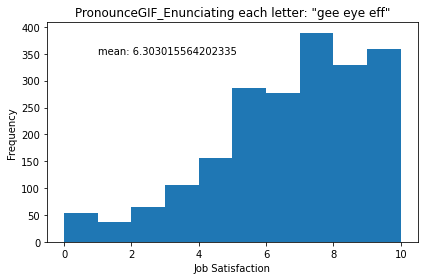

PronounceGIF_Some other way 6.977077363896848


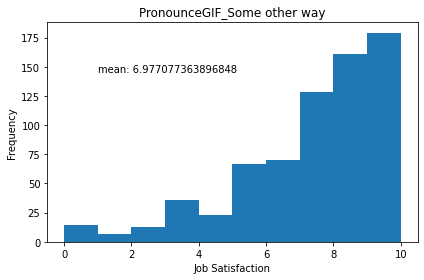

PronounceGIF_With a hard "g," like "gift" 7.05585439540196


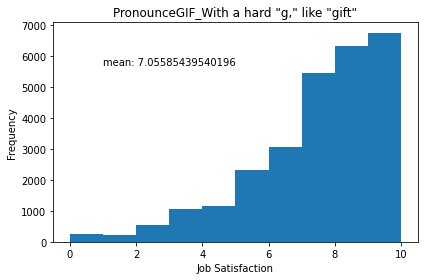

PronounceGIF_With a soft "g," like "jiff" 6.829417475728155


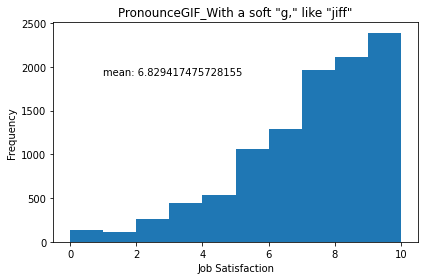

In [4]:
gif_cols =  [label for label in data.columns.values if 'GIF' in label]
for label in gif_cols:
    gif_dats = data['JobSatisfaction'][data[label].astype(bool)]
    print(label, gif_dats.mean())
    
    plt.hist(gif_dats)
    plt.xlabel('Job Satisfaction')
    plt.ylabel('Frequency')
    plt.title(label)

    plt.text(1, 0.9 * gif_dats.value_counts().max(), 'mean: ' + str(gif_dats.mean()))
    plt.tight_layout()
    plt.savefig(label.replace("\"","'"))
    plt.show()

In [ ]:
searcher = GridSearchCV(xgb.XGBRegressor(), {
    'max_depth': [4], # tested 2,3,4,5,7,9
    'min_child_weight': [7], # tested 1,3,5,6,7,8
    'gamma': [0], # tested 0,0.1,0.2,1,2
    'n_estimators': [15000],
    'subsample': [0.8], # tested 0.6,0.7,0.8,0.9
    'colsample_bytree': [0.6], # tested 0.5,0.6,0.7,0.8,0.9
    'scale_pos_weight': [1],
    'reg_alpha': [1], # tested 1e-5, 1e-2, 0.1, 1, 10, 100
    'reg_lambda': [100], # tested 1e-5, 1e-2, 0.1, 1, 10, 100
    'learning_rate': [0.001],
}, cv=3, scoring='neg_mean_squared_error', verbose=10, n_jobs=4)

searcher.fit(data.drop(['JobSatisfaction'], axis=1), data['JobSatisfaction'])
print(searcher.best_params_)
print(searcher.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [5]:
searcher = GridSearchCV(xgb.XGBRegressor(), {
    'max_depth': [4], # tested 2,3,4,5,7,9
    'min_child_weight': [7], # tested 1,3,5,6,7,8
    'gamma': [0], # tested 0,0.1,0.2,1,2
    'n_estimators': [1500],
    'subsample': [0.8], # tested 0.6,0.7,0.8,0.9
    'colsample_bytree': [0.6], # tested 0.5,0.6,0.7,0.8,0.9
    'scale_pos_weight': [1],
    'reg_alpha': [1], # tested 1e-5, 1e-2, 0.1, 1, 10, 100
    'reg_lambda': [100], # tested 1e-5, 1e-2, 0.1, 1, 10, 100
    'learning_rate': [0.01],
}, cv=3, scoring='neg_mean_squared_error', verbose=10, n_jobs=4)

searcher.fit(data.drop(['JobSatisfaction'], axis=1), data['JobSatisfaction'])
print(searcher.best_params_)
print(searcher.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 1500, 'reg_alpha': 1, 'reg_lambda': 100, 'scale_pos_weight': 1, 'subsample': 0.8}
-2.371558444481166


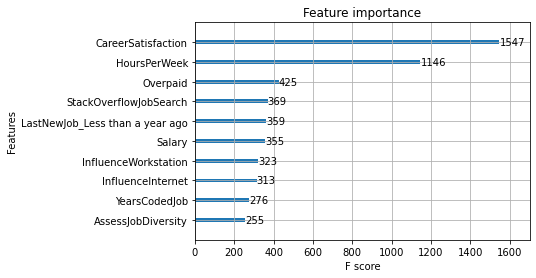

In [6]:
xgb.plot_importance(searcher.best_estimator_, max_num_features=10)
plt.show()

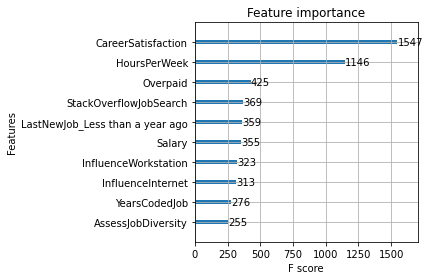

In [7]:
xgb.plot_importance(searcher.best_estimator_, max_num_features=10)
plt.tight_layout()
plt.savefig('feat_importance.png')

In [3]:
X = data[['CareerSatisfaction',
          'HoursPerWeek',
          'Overpaid',
          'LastNewJob_Less than a year ago',
          'InfluenceWorkstation',
          'Salary',
         ]]
y = data['JobSatisfaction']

small_model = xgb.XGBRegressor(
    max_depth=4,
    min_child_weight=7,
    gamma=0,
    n_estimators=1500,
    subsample=0.8,
    colsample_bytree=0.6,
    scale_pos_weight=1,
    reg_alpha=1,
    reg_lambda=100,
    learning_rate=0.01,
)
small_model.fit(X, y)
small_model._Booster.save_model('output2017.model')

In [9]:
model = xgb.XGBRegressor()
rfe = RFE(model, n_features_to_select=100, step=5, verbose=10)
rfe = rfe.fit(X,y)
# rfe.transform(X_train)
# rfe.transform(X_test)
for feat in np.ma.masked_array(X.columns.values, mask=rfe.support_):
    print(feat)

--
--
--
--
--
--


In [4]:
X = data.drop(['JobSatisfaction'], axis=1)
y = data['JobSatisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)

In [5]:
from sklearn.metrics import mean_absolute_error

X = data[['CareerSatisfaction',
          'HoursPerWeek',
          'Overpaid',
          'LastNewJob_Less than a year ago',
          'InfluenceWorkstation',
          'Salary',
         ]]
y = data['JobSatisfaction']

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3,stratify=y)

from sklearn.linear_model import LassoCV
small_model = LassoCV(alphas=[0.01, 0.1, 1, 10, 100, 2017])
small_model.fit(X_train_sm, y_train_sm)
preds = np.clip(small_model.predict(X_test_sm), 0, 10)
print(mean_squared_error(preds, y_test_sm) ** 0.5)
print(mean_absolute_error(preds, y_test_sm))

1.6407360937051048
1.2115132795979096


In [6]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
ridge = RidgeCV(alphas=[217.0])
ridge.fit(X_train, y_train)
preds = ridge.predict(X_test)
print(mean_squared_error(np.clip(preds, 0, 10), y_test) ** 0.5)
print(mean_absolute_error(np.clip(preds, 0, 10), y_test))
print(ridge.alpha_)
# X_train.columns[np.where(np.abs(ridge.coef_) > 0.1)].values

1.5641650756251282
1.1616852729980434
217.0


In [7]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error
lasso = LassoCV(alphas=[0.01, 0.1, 1, 10, 100, 2017])
lasso.fit(X_train, y_train)
preds = lasso.predict(X_test)
print(mean_squared_error(np.clip(preds, 0, 10), y_test) ** 0.5)
print(mean_absolute_error(np.clip(preds, 0, 10), y_test))
print(lasso.alpha_)
# X_train.columns[np.where(np.abs(lasso.coef_) > 0.1)].values

1.5766617206825577
1.169147635224575
0.01


In [8]:
import tensorflow as tf
import keras
import theano
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
# tf.logging.set_verbosity(tf.logging.INFO)
np.random.seed(123)  # for reproducibility
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

np.random.seed(42)  # for reproducibility

model = Sequential()
model.add(Dense(811, input_dim=811, activation='relu'))
#model.add(Dense(200, activation='sigmoid'))
model.add(Dense(400, activation='hard_sigmoid'))
model.add(Dense(200, activation='hard_sigmoid'))
model.add(Dense(100, activation='hard_sigmoid'))
#model.add(Dense(50, activation='hard_sigmoid'))
#model.add(Dense(40, activation='sigmoid'))
#model.add(Dense(10, activation='sigmoid'))
#model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(lr=.0001))

model.fit(X_train, y_train, epochs=199, batch_size=1000)

nn_preds = model.predict(X_test)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Epoch 1/199
29/29 [==============================] - 2s 56ms/step - loss: 6.9570

In [ ]:
from sklearn.tree import ExtraTreeRegressor
etr = ExtraTreeRegressor(max_depth=10)

etr.fit(X_train, y_train)
preds = etr.predict(X_test)
print(mean_squared_error(np.clip(preds, 0, 10), y_test) ** 0.5)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=10, n_estimators=300)

rfr.fit(X_train, y_train)
preds = rfr.predict(X_test)
print(mean_squared_error(np.clip(preds, 0, 10), y_test) ** 0.5)

In [ ]:
xgb_model = xgb.XGBRegressor(
    max_depth=4,
    min_child_weight=7,
    gamma=0,
    n_estimators=1500,
    subsample=0.8,
    colsample_bytree=0.6,
    scale_pos_weight=1,
    reg_alpha=1,
    reg_lambda=100,
    learning_rate=0.01
)

ens_model = AdaBoostRegressor(base_estimator=xgb_model)
ens_model.fit(X_train, y_train)
preds = ens_model.predict(X_test)
mean_squared_error(preds, y_test)

In [ ]:
# MSE 2.5054
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
mean_squared_error(preds, y_test)

In [ ]:
# MSE 2.32575
xgb_model = xgb.XGBRegressor(
    max_depth=4,
    min_child_weight=7,
    gamma=0,
    n_estimators=15000,
    subsample=0.8,
    colsample_bytree=0.6,
    scale_pos_weight=1,
    reg_alpha=1,
    reg_lambda=100,
    learning_rate=0.001
)

xgb_model.fit(X_train, y_train)
preds = np.clip(xgb_model.predict(X_test), 0, 10)
print(mean_squared_error(preds, y_test))

In [ ]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()